# Algonauts 2023 Encoding Model Demo

This notebook runs a full encoding model pipeline:

1. Load Algonauts fMRI training data for one subject  
2. Extract ResNet50 features for each stimulus image  
3. Fit a Ridge regression encoding model (X → Y)  
4. Compute voxel-wise R² on held-out data  
5. Visualize the R² distribution


## Imports

In [1]:
import os
import numpy as np
from pathlib import Path
from tqdm import tqdm

from algonauts_data_loading import load_train_subject_roi, TRAIN_DIR
from feature_extraction import extract_resnet_avgpool_features  
from model_fitting import fit_ridge_encoding_model
from evaluation import compute_voxel_r2, summarize_r2
from visualization import plot_r2_histogram


In [2]:
# Choose which subject to run
subject = "subj01-009"   

# Feature caching directory 
FEATURE_DIR = Path("data") / "features"
FEATURE_DIR.mkdir(parents=True, exist_ok=True)

feature_file = FEATURE_DIR / f"{subject}_resnet50_features.npy"

print("Subject:", subject)
print("Feature cache path:", feature_file)


Subject: subj01-009
Feature cache path: data/features/subj01-009_resnet50_features.npy


In [3]:
# Load training data for the chosen subject
# NOTE: loader returns ONLY (img_ids, fmri)
img_ids_train, fmri_train = load_train_subject_roi(
    subject=subject,
    roi_tag=None,   # currently unused in your loader
)

print("Loaded fMRI + image IDs:")
print("  img_ids_train shape:", img_ids_train.shape)
print("  fmri_train shape   :", fmri_train.shape)

# --- Rebuild image paths in the SAME WAY as the loader ---

# 1) Locate the subject root inside TRAIN_DIR (same as in the .py file)
subj_root = os.path.join(TRAIN_DIR, subject)
print("Subject root:", subj_root)

inner_dirs = [
    d for d in os.listdir(subj_root)
    if os.path.isdir(os.path.join(subj_root, d))
]
if not inner_dirs:
    raise RuntimeError(f"No inner subject folder found inside {subj_root}.")

# Your loader just takes inner_dirs[0], so we do the same
inner_subj = inner_dirs[0]
print("Using inner subject folder:", inner_subj)

subj_dir = os.path.join(subj_root, inner_subj)

# 2) training_images/ directory
img_dir = os.path.join(subj_dir, "training_split", "training_images")
print("Image directory:", img_dir)

# 3) Sort filenames exactly as the loader does
png_files = sorted(
    f for f in os.listdir(img_dir)
    if f.lower().endswith(".png")
)

if len(png_files) != fmri_train.shape[0]:
    print("Warning: #images != #fMRI trials")
    print("  N images:", len(png_files))
    print("  N fMRI  :", fmri_train.shape[0])

# 4) Build full paths in that same order
img_paths_train = [
    os.path.join(img_dir, fname)
    for fname in png_files
]

print("Reconstructed image paths:")
print("  #img_paths_train:", len(img_paths_train))
print("  Example path     :", img_paths_train[0])



Subject root: /Users/leoa.antonio/neuroai-model-brain-mapping/encoding_models/data/train_data/subj01-009
Using inner subject folder: /Users/leoa.antonio/neuroai-model-brain-mapping/encoding_models/data/train_data/subj01-009/subj01
Loaded hemisphere fMRI:
  LH shape: (9841, 19004)
  RH shape: (9841, 20544)

Loaded arrays:
  img_ids shape: (9841,)
  fmri shape: (9841, 39548)
Loaded fMRI + image IDs:
  img_ids_train shape: (9841,)
  fmri_train shape   : (9841, 39548)
Subject root: /Users/leoa.antonio/neuroai-model-brain-mapping/encoding_models/data/train_data/subj01-009
Using inner subject folder: subj01
Image directory: /Users/leoa.antonio/neuroai-model-brain-mapping/encoding_models/data/train_data/subj01-009/subj01/training_split/training_images
Reconstructed image paths:
  #img_paths_train: 9841
  Example path     : /Users/leoa.antonio/neuroai-model-brain-mapping/encoding_models/data/train_data/subj01-009/subj01/training_split/training_images/train-0001_nsd-00013.png


In [4]:
if feature_file.exists():
    print("Loading cached features from disk...")
    X = np.load(feature_file)
else:
    print("Extracting ResNet50 avgpool features (batched)...")
    X = extract_resnet_avgpool_features(img_paths_train)
    np.save(feature_file, X)
    print("Saved features to:", feature_file)

print("Feature matrix shape:", X.shape)  # expect (N_trials, 2048)




Loading cached features from disk...
Feature matrix shape: (9841, 2048)


In [7]:
# Cell 6 — Fit the encoding model (Ridge, single alpha)

result = fit_ridge_encoding_model(
    X,
    fmri_train,
    alpha=100.0,    
    test_size=0.2,
    random_state=0,
    standardize=True,
)
print("Training complete.")
print("  Train samples:", len(result.train_idx))
print("  Test samples :", len(result.test_idx))




[model_fitting] X shape: (9841, 2048)
[model_fitting] Y shape: (9841, 39548)
[model_fitting] Train samples: 7872
[model_fitting] Test samples : 1969
[model_fitting] Standardized features with StandardScaler.
[model_fitting] Fitting Ridge(alpha=100.0) on full voxel matrix...
[model_fitting] Finished training.
[model_fitting] Finished test-set prediction.
[model_fitting] Y_pred_test shape: (1969, 39548)
Training complete.
  Train samples: 7872
  Test samples : 1969


In [8]:
# Cell 7 — Compute voxel-wise R² on held-out data

Y_test = fmri_train[result.test_idx]
Y_pred = result.y_pred_test

r2_voxels = compute_voxel_r2(Y_test, Y_pred)
mean_r2, median_r2, frac_positive = summarize_r2(r2_voxels)


Voxel-wise R² summary:
  mean R²        : -0.0877
  median R²      : -0.1198
  % R² > 0       : 26.3%


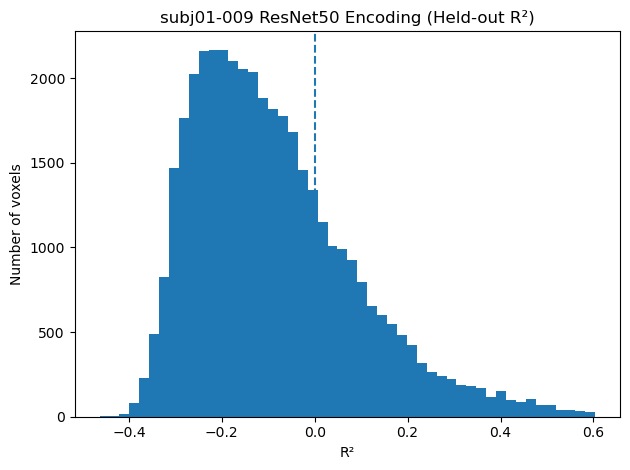

In [9]:
# Cell 8 — Visualize voxel-wise R² distribution

plot_r2_histogram(
    r2_voxels,
    bins=50,
    title=f"{subject} ResNet50 Encoding (Held-out R²)"
)
